# Processing of forms 

download link : - https://console.cloud.google.com/storage/browser/height_maps 
new downlaod link : https://drive.google.com/drive/folders/1ytJ3N9Braip0LogY-4R7WMkfjzan0VzP 

## Preprocessing rasters 

Resampling at 30m resolution divide by 10 the size of the raster but for computing the fractal dimension it is better to have a resolution of 10m. 


### Downsampling to 30m

In [55]:
#Resampling at 30m 
directory = '/Users/arthurcalvi/Data/Disturbances_maps/FORMS'
new_directory = '/Users/arthurcalvi/Data/Disturbances_maps/FORMS/int2/'

import numpy as np
import rasterio
from rasterio.enums import Resampling
import os
from tqdm import tqdm 
import matplotlib.pyplot as plt

os.makedirs(new_directory, exist_ok=True)
for filename in tqdm([x for x in os.listdir(directory) if x.endswith('.tif')]):

    input_file = os.path.join(directory, filename)
    output_file = os.path.join(new_directory, filename)

    # Define the scaling factor
    scale_factor = 10 / 30

    with rasterio.open(input_file) as dataset:

        # Define the new transform and dimensions
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / (dataset.width * scale_factor)),
            (dataset.height / (dataset.height * scale_factor))
        )
        new_width = int(dataset.width * scale_factor)
        new_height = int(dataset.height * scale_factor)

        profile = dataset.profile
        profile.update(transform=transform, driver='GTiff', height=new_height, width=new_width, compress='lzw')

        with rasterio.open(output_file, 'w', **profile) as dst:
            for ji, window in tqdm(dataset.block_windows(1)):

                # Calculate window size in new raster
                # window_transform = dataset.window_transform(window)
                new_window = rasterio.windows.Window(
                    window.col_off * scale_factor,
                    window.row_off * scale_factor,
                    window.width * scale_factor,
                    window.height * scale_factor
                )

                data = dataset.read(
                    window=window, 
                    out_shape=(
                        dataset.count,
                        int(window.height * scale_factor),
                        int(window.width * scale_factor)
                    ),
                    resampling=Resampling.bilinear
                )

                # if data.mean() != 32767:
                #     break

                # nodata = (data == 32767.)
                # data = (data / 200).astype('uint8')
                # data[ nodata ] = 255
                
                dst.write(data.astype('int16'), window=new_window)


  0%|          | 0/4 [00:00<?, ?it/s]

49416it [01:30, 547.52it/s] 
49416it [01:32, 532.80it/s] 04:34, 91.59s/it]
49416it [01:30, 546.90it/s] 03:06, 93.03s/it]
49416it [01:30, 549.03it/s] 01:32, 92.40s/it]
100%|██████████| 4/4 [06:08<00:00, 92.15s/it]


### Directly performing the difference and conversion to uint8 by block without resampling

In [604]:
import rasterio
import os 
from tqdm import tqdm

directory = '/Users/arthurcalvi/Data/Disturbances_maps/FORMS/'
output_directory = '/Users/arthurcalvi/Data/Disturbances_maps/FORMS/difference/'
os.makedirs(output_directory, exist_ok=True)

for year in range(2019, 2020):
    year1 = str(year)
    year2 = str(year+1)
    raster1_name = os.path.join(directory, f'{year1}_l93.tif')
    raster2_name = os.path.join(directory, f'{year2}_l93.tif')

    # Open the two raster datasets
    with rasterio.open(raster1_name) as src1, rasterio.open(raster2_name) as src2:

        # Ensure the rasters are compatible (e.g., dimensions, CRS)
        # This step is crucial to avoid errors during processing

        # Prepare the output raster
        profile = src1.profile
        profile.update(compress='lzw', dtype='uint8', nodata=0)
        with rasterio.open(os.path.join(output_directory, f'diff_{year1}_{year2}.tif'), 'w', **profile, nbits=1) as dst:

            # Process each block
            for ji, window in tqdm(src1.block_windows(1)):
                block1 = src1.read(window=window)
                block2 = src2.read(window=window)

                # Perform the difference operation
                result_block = block1 - block2
                result_block[ block2 > 500 ] = 32767 # on garde les zones sans arbres (- de 5m) à l'année suivante 
                result_block[ result_block < 500 ] = 32767 # coupe de moins de 5m (ARBRE adulte ~ 5m  RMSE de ~ 3m) ou croissance -> nodata 
                result_block[ result_block > 32767 - 5000 ] = 32767 # erreurs au niveau des bords (plus haut arbre ~ 50m) -> nodata

                nodata = (result_block == 32767.)
                #mapping from height in cm in int16 to height in dm/2 in uint8

                #conversion to classes 0 -> nodata, 1 -> 0-10m, 2 -> 10-20m, 3 -> 20m+
                result_block[ result_block == 32767 ] = 0
                # result_block[ (result_block > 0) & (result_block < 1000) ] = 1
                # result_block[ (result_block >= 1000) & (result_block < 2000) ] = 2
                # result_block[ result_block >= 2000 ] = 3
                result_block[ result_block > 0 ] = 1
                result_block = result_block.astype('uint8')

                # Write the result to the new raster
                dst.write(result_block, window=window)


0it [00:00, ?it/s]

49416it [05:05, 161.53it/s]


### Convert to geodataframe and filtering

In [125]:
def count_segments(polygon):
    # Counting segments in exterior
    exterior_segments = len(polygon.exterior.coords) - 1
    # Counting segments in interiors (holes)
    # interior_segments = sum(len(interior.coords) - 1 for interior in polygon.interiors)
    return exterior_segments #+ interior_segments

# Calculate fractal dimensions using the number of segments
def calculate_fractal_dimension(geom, num_segments):
    if geom.area == 0 or num_segments == 0:  # To avoid division by zero
        return np.nan
    return 2 * np.log(num_segments) / np.log(geom.area)

from shapely.geometry import Polygon
def has_large_hole(polygon, threshold=100):
    for interior in polygon.interiors:
        if Polygon(interior).area > threshold:
            return True
    return False

from shapely.geometry import Polygon, Point
import math
import numpy as np 

def calculate_angle(p1, p2, p3, p4):
    """
    Calculate the angle between two vectors formed by the segments p1-p2 and p3-p4.
    """
    vector_1 = (p2.x - p1.x, p2.y - p1.y)
    vector_2 = (p4.x - p3.x, p4.y - p3.y)

    dot_product = vector_1[0] * vector_2[0] + vector_1[1] * vector_2[1]
    magnitude_1 = math.sqrt(vector_1[0]**2 + vector_1[1]**2)
    magnitude_2 = math.sqrt(vector_2[0]**2 + vector_2[1]**2)

    if magnitude_1 * magnitude_2 == 0:
        return 0  # Avoid division by zero

    try :
        angle = math.acos(dot_product / (magnitude_1 * magnitude_2))
    except:
        # print(dot_product, magnitude_1, magnitude_2)
        angle = 45
        
    return math.degrees(angle)

def count_perpendicular_segments(polygon, tolerance=10):
    """
    Count the number of segments in a polygon that are approximately perpendicular to each other.
    Tolerance is the degree deviation allowed from 90 degrees to still be considered perpendicular.
    """
    coords = list(polygon.exterior.coords)
    perp_count = 0

    for i in range(len(coords) - 1):
        for j in range(len(coords) - 1):
            if i != j:
                angle = calculate_angle(Point(coords[i]), Point(coords[i+1]), Point(coords[j]), Point(coords[j+1]))
                if 90 - tolerance <= angle <= 90 + tolerance:
                    perp_count += 1

                if 180 - tolerance <= angle <= 180 + tolerance:
                    perp_count += 1

    return perp_count

def is_polygon_valid(polygon, threshold=0.56):
    polygon = polygon.simplify(10)
    num_segments = count_segments(polygon)
    return polygon.is_simple and not has_large_hole(polygon, 10**2) and calculate_fractal_dimension(polygon, num_segments) < threshold and count_perpendicular_segments(polygon, 15) / num_segments >= 2.


In [126]:
#Converting to GeoDataFrame (~8min)

from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import os 

#masking nodata
import numpy.ma as ma 
list_gdf = []
directory = '/Users/arthurcalvi/Data/Disturbances_maps/FORMS/'
output_directory = '/Users/arthurcalvi/Data/Disturbances_maps/FORMS/difference/'
for filename in os.listdir(output_directory):

    year1, year2 = filename.split('_')[1:]
    year2 = year2.split('.')[0]

    difference = rasterio.open(os.path.join(output_directory, filename)).read(1)
    mask = (difference == 0) 
    array_ma = ma.masked_array(difference, mask=mask)

    raster = rasterio.open(os.path.join(directory, f'{year2}_l93.tif'))
    shape_gen = ((shape(s), int(v)) for s,v in  shapes(array_ma, transform=raster.transform))
    gdf1 = gpd.GeoDataFrame(dict(zip(["geometry", "cat"], zip(*shape_gen))), crs=raster.crs)

    #filter for area > 0.5ha = 5000m2
    gdf1['area'] = gdf1.area
    gdf1 = gdf1[ gdf1['area'] > 5000 ]

    gdf1['is_valid'] = gdf1['geometry'].apply(is_polygon_valid)

    print('Percentage of valid polygons : ', gdf1['is_valid'].mean() * 100)

    #add start_date 09/year1 and end_date 05/year2 
    gdf1['start_date'] = f'09-{year1}'
    gdf1['end_date'] = f'05-{year2}'

    gdf1 = gdf1[ gdf1['is_valid'] ]
    list_gdf.append(gdf1)

import pandas as pd

gdf = gpd.GeoDataFrame(pd.concat(list_gdf, ignore_index=True), crs=raster.crs)

gdf.to_parquet(f'../data/processed_datasets/FORMS_clearcut_2017_2020_EPSG2154.parquet')
    
    

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Percentage of valid polygons :  53.9028539028539


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Percentage of valid polygons :  54.23139158576051


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Percentage of valid polygons :  54.14947450369794


In [610]:
gdf

,geometry,cat,area,is_valid,start_date,end_date
0,"POLYGON ((670500.159 7110108.901, 670520.159 7...",1,5500.0,True,09-2017,05-2018
1,"POLYGON ((662830.159 7107228.901, 662830.159 7...",1,6400.0,True,09-2017,05-2018
2,"POLYGON ((669220.159 7105688.901, 669250.159 7...",1,17100.0,True,09-2017,05-2018
3,"POLYGON ((660550.159 7104538.901, 660590.159 7...",1,5500.0,True,09-2017,05-2018
4,"POLYGON ((668310.159 7104538.901, 668320.159 7...",1,9400.0,True,09-2017,05-2018
...,...,...,...,...,...,...
53879,"POLYGON ((1232620.159 6123618.901, 1232650.159...",1,6500.0,True,09-2018,05-2019
53880,"POLYGON ((1182220.159 6101878.901, 1182300.159...",1,7000.0,True,09-2018,05-2019
53881,"POLYGON ((1189450.159 6089228.901, 1189470.159...",1,11400.0,True,09-2018,05-2019
53882,"POLYGON ((1232930.159 6088928.901, 1232980.159...",1,8900.0,True,09-2018,05-2019


## Simplified version

In [128]:
import geopandas as gpd
bdforet30 = gpd.read_parquet('../data/processed_datasets/BDFORET_EPSG2154_FR_simplified30.parquet')

import pandas as pd
import numpy as np

def get_tree_species(row):
    index = bdforet30.sindex.query(row.geometry, predicate='intersects')
    if len(index) == 1:
        index = index[0]
        return bdforet30.iloc[index][['tree_type', 'essence']]
    elif len(index) > 1:
        sub = bdforet30.iloc[index]
        if len(sub.tree_type.unique().tolist()) > 1:
            tree_type = 'Mixed' 
        else : 
            tree_type = sub.tree_type.iloc[0] if type(sub.tree_type.iloc[0]) == str else np.nan 
        essence = ",".join([x for x in sub.essence.unique().tolist() if type(x) == str])
        #put in a pandas series with tree_type and essence as row names
        return pd.Series([tree_type, essence], index=['tree_type', 'essence'])
    else :
        return None, None

gdf[['tree_type', 'essence']] = gdf.apply(get_tree_species, axis=1, result_type='expand')

In [129]:
#convert start-date MM-YY to datetime 
gdf['start_date'] = pd.to_datetime(gdf['start_date'], format='%m-%Y')
gdf['end_date'] = pd.to_datetime(gdf['end_date'], format='%m-%Y')
gdf['class'] = 'clear-cut'
gdf[['geometry', 'start_date', 'end_date', 'class', 'tree_type', 'essence']].to_crs('EPSG:3857').to_crs('EPSG:2154').to_parquet(f'../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet')

In [1]:
import geopandas as gpd
gdf = gpd.read_parquet(f'../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet')
gdf['class'] = 'clear-cut'
gdf.to_crs('EPSG:3857').to_crs('EPSG:2154').to_parquet(f'../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet')

In [622]:
a = gdf['geometry'].apply(lambda x: x.is_valid)

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


## Analysis

In [45]:
import matplotlib.pyplot as plt

raster = rasterio.open('/Users/arthurcalvi/Data/Disturbances_maps/FORMS/difference/diff_2018_2019.tif').read(1)
# plt.imshow(raster)
# plt.colorbar()

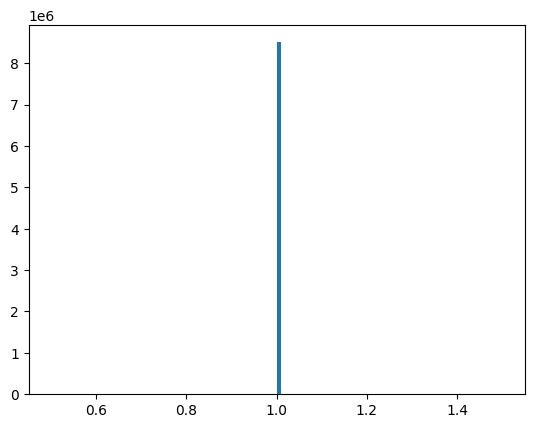

In [46]:
a = raster[ raster != 0 ]
_ = plt.hist(a.flatten(), bins=100)

## Conversion to GeoDataFrame

In [3]:
#Converting to GeoDataFrame (~8min)
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd

#masking nodata
import numpy.ma as ma 

raster = rasterio.open('/Users/arthurcalvi/Data/Disturbances_maps/FORMS/difference/diff_2018_2019.tif')
difference = raster.read(1)
mask = (difference == 0) 
array_ma = ma.masked_array(difference, mask=mask)

shape_gen = ((shape(s), int(v)) for s,v in  shapes(array_ma, transform=raster.transform))
gdf1 = gpd.GeoDataFrame(dict(zip(["geometry", "cat"], zip(*shape_gen))), crs=raster.crs)

#filter for area > 0.5ha = 5000m2
gdf1['area'] = gdf1.area
gdf1 = gdf1[ gdf1['area'] > 5000 ]
gdf1.shape

(25690, 3)

In [26]:
p1 = Point(0, 0)
p2 = Point(1, 0)
p3 = Point(0, 1)

calculate_angle(p2, p1, p1, p3)

90.0

is simple :  True | has rings :  False
area :  5200.0 | length :  420.0 | fractal dimension :  0.7002307992497024


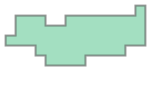

In [76]:
from shapely.geometry import Polygon, Point
import math
import numpy as np 

def calculate_angle(p1, p2, p3, p4):
    """
    Calculate the angle between two vectors formed by the segments p1-p2 and p3-p4.
    """
    vector_1 = (p2.x - p1.x, p2.y - p1.y)
    vector_2 = (p4.x - p3.x, p4.y - p3.y)

    dot_product = vector_1[0] * vector_2[0] + vector_1[1] * vector_2[1]
    magnitude_1 = math.sqrt(vector_1[0]**2 + vector_1[1]**2)
    magnitude_2 = math.sqrt(vector_2[0]**2 + vector_2[1]**2)

    if magnitude_1 * magnitude_2 == 0:
        return 0  # Avoid division by zero

    try :
        angle = math.acos(dot_product / (magnitude_1 * magnitude_2))
    except:
        print(dot_product, magnitude_1, magnitude_2)
        angle = 0 
        
    return math.degrees(angle)

def count_perpendicular_segments(polygon, tolerance=10):
    """
    Count the number of segments in a polygon that are approximately perpendicular to each other.
    Tolerance is the degree deviation allowed from 90 degrees to still be considered perpendicular.
    """
    coords = list(polygon.exterior.coords)
    perp_count = 0

    for i in range(len(coords) - 1):
        for j in range(len(coords) - 1):
            if i != j:
                angle = calculate_angle(Point(coords[i]), Point(coords[i+1]), Point(coords[j]), Point(coords[j+1]))
                if 90 - tolerance <= angle <= 90 + tolerance:
                    perp_count += 1

                if 180 - tolerance <= angle <= 180 + tolerance:
                    perp_count += 1

    return perp_count



# filtered_polygons now contains polygons with at least the threshold number of perpendicular segments


def count_segments(polygon):
    # Counting segments in exterior
    exterior_segments = len(polygon.exterior.coords) - 1
    # Counting segments in interiors (holes)
    # interior_segments = sum(len(interior.coords) - 1 for interior in polygon.interiors)
    return exterior_segments #+ interior_segments

# Calculate fractal dimensions using the number of segments
def calculate_fractal_dimension(geom):
    num_segments = count_segments(geom)
    if geom.area == 0 or num_segments == 0:  # To avoid division by zero
        return np.nan
    return 2 * np.log(num_segments) / np.log(geom.area)


index = 100
geo = gdf1.iloc[index].geometry
print('is simple : ', geo.is_simple, '| has rings : ', len(geo.interiors) > 0)
print('area : ', geo.area, '| length : ', geo.length, '| fractal dimension : ', calculate_fractal_dimension(geo))
geo 


In [59]:
index = 0

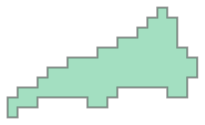

is simple :  True | has large holes :  False
nbr segments :  9 | nbr perpendicular segments :  18 | ratio :  2.0
area :  8350.0 | length :  502.77813675377604 | fractal dimension :  0.48664905540244785
kept : True


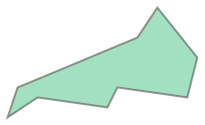

In [116]:

threshold = 0.56

from shapely.geometry import Polygon
def has_large_hole(polygon, threshold=100):
    for interior in polygon.interiors:
        if Polygon(interior).area > threshold:
            return True
    return False

geo =  gdf1.iloc[index].geometry
display(geo)
geo = geo.simplify(10)
cond = geo.is_simple and not has_large_hole(geo, 10**2) and calculate_fractal_dimension(geo) < threshold and count_perpendicular_segments(geo, 15) >= 2 * count_segments(geo)
print('is simple : ', geo.is_simple, '| has large holes : ', has_large_hole(geo, 15**2))
print('nbr segments : ', count_segments(geo), '| nbr perpendicular segments : ', count_perpendicular_segments(geo, 15), '| ratio : ', count_perpendicular_segments(geo, 15) / count_segments(geo))
print('area : ', geo.area, '| length : ', geo.length, '| fractal dimension : ', calculate_fractal_dimension(geo))
print('kept :', cond )
display(geo)

index+=1

In [593]:
def is_polygon_valid(polygon, threshold=0.56):
    polygon = polygon.simplify(10)
    return polygon.is_simple and not has_large_hole(polygon, 10**2) and calculate_fractal_dimension(polygon) < threshold

gdf1['is_valid'] = gdf1['geometry'].apply(is_polygon_valid)

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [594]:
#percentage of valid polygons
gdf1['is_valid'].mean()

0.6981315687037758

In [ ]:
#add start_date = 09/2018 and end_date = 05/2019


In [597]:
gdf1 = gdf1[ gdf1['is_valid'] ]
gdf1.to_parquet('../data/processed_datasets/FORMS_clearcut_2018_2019_EPSG2154.parquet')

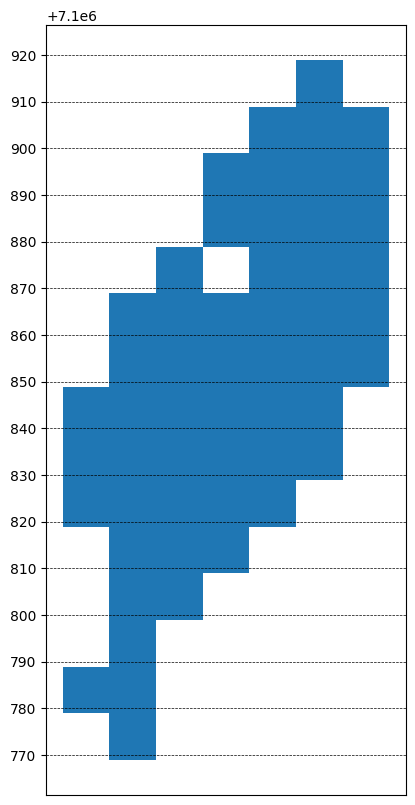

In [51]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
index = 3
gdf1.iloc[index:index+1].plot(ax=ax)
#add grid every 10m on the x and y axis with mpl MutipleLocator
from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(10)
ax.xaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.grid(which='major', axis='x', linestyle='--', color='k', linewidth=0.5)
ax.grid(which='major', axis='y', linestyle='--', color='k', linewidth=0.5)


## Misc

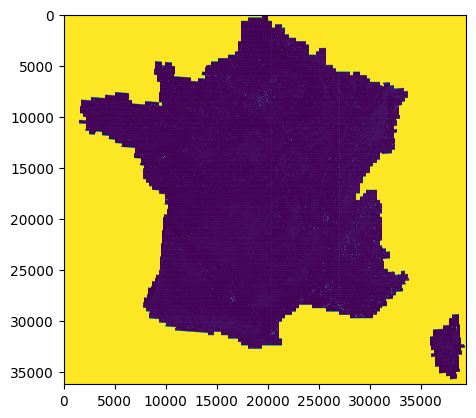

In [51]:
import matplotlib.pyplot as plt

raster = rasterio.open('/Users/arthurcalvi/Data/Disturbances_maps/FORMS/int2/2018_l93.tif').read(1)
plt.imshow(raster)

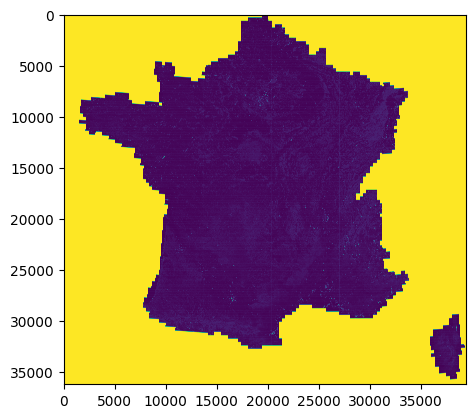

In [44]:
import matplotlib.pyplot as plt

raster = rasterio.open('/Users/arthurcalvi/Data/Disturbances_maps/FORMS/int2/2018_l93.tif').read(1)
plt.imshow(raster)

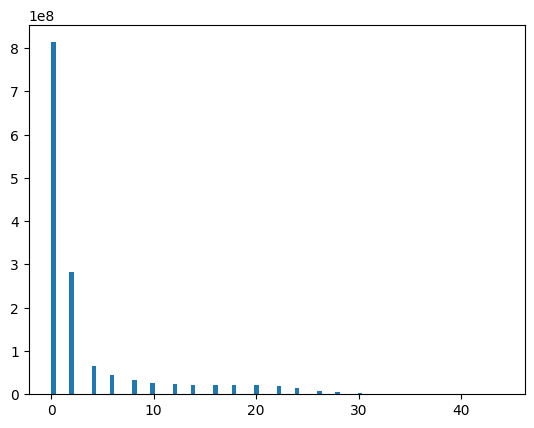

In [54]:
raster[ raster == 255 ] = 0
a = raster.flatten() * 2
_ = plt.hist(a , bins=100)

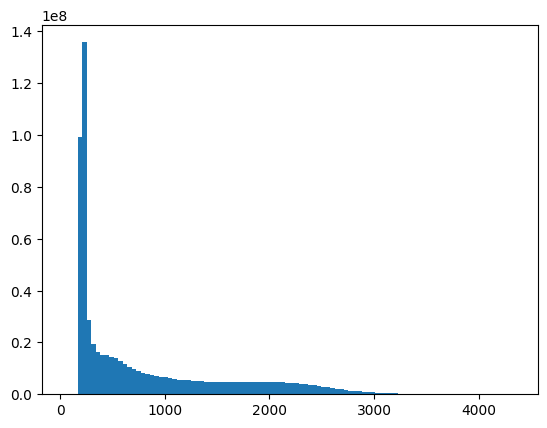

In [74]:

a = raster19[ raster19 != 32767 ].flatten() 
_ = plt.hist(a , bins=100)

### Successive clear cut

en cm

In [1]:
import rasterio
import os 

directory = '/Users/arthurcalvi/Data/Disturbances_maps/FORMS/int2'

raster18 = rasterio.open(os.path.join(directory, '2018_l93.tif')).read(1)
raster19 = rasterio.open(os.path.join(directory, '2019_l93.tif')).read(1)

In [54]:
difference = raster18 - raster19
difference[ raster19 > 500 ] = 32767 # on garde les zones sans arbres (- de 5m) à l'année suivante 
difference[ difference < 800 ] = 32767 # coupe de moins de 8m (ARBRE adulte ~ 5m  RMSE de ~ 3m) ou croissance -> nodata 
difference[ difference > 32767 - 5000 ] = 32767 # erreurs au niveau des bords (plus haut arbre ~ 50m) -> nodata

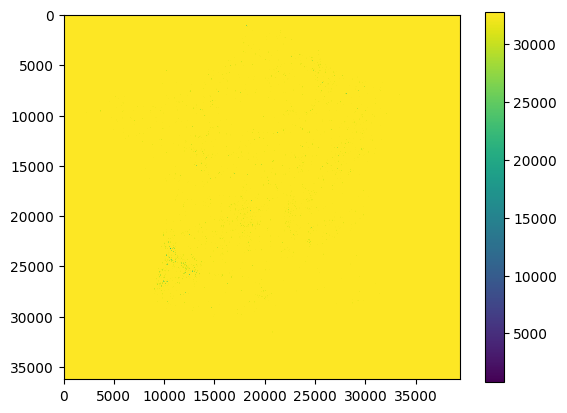

In [55]:
plt.imshow(difference)
plt.colorbar()

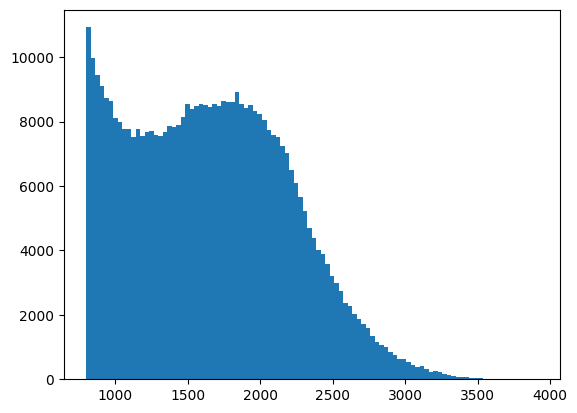

In [56]:
_ = plt.hist(difference[ difference != 32767 ].flatten(), bins=100)

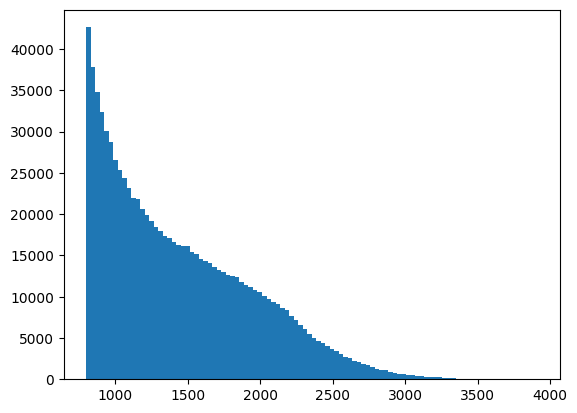

In [84]:
_ = plt.hist(difference[ difference != 32767 ].flatten(), bins=100)

In [57]:
#classify in 3 classes : < 10m, 10-20m, > 20m
difference[ difference == 32767 ] = 0
difference[ (difference > 0) & (difference < 1000) ] = 1
difference[ (difference >= 1000) & (difference < 2000) ] = 2
difference[ difference >= 2000 ] = 3
difference = difference.astype('uint8')
# plt.imshow(difference)
# plt.colorbar()

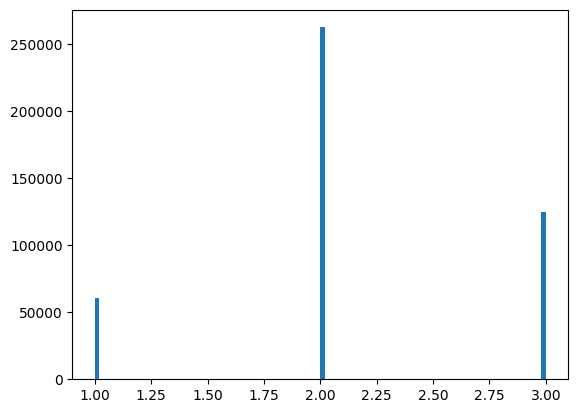

In [58]:
_ = plt.hist(difference[ difference != 0 ].flatten(), bins=100)

In [59]:
#Converting to GeoDataFrame (~8min)

from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd

#masking nodata
import numpy.ma as ma 

mask = (difference == 0) 
array_ma = ma.masked_array(difference, mask=mask)

raster = rasterio.open(os.path.join(directory, '2018_l93.tif'))
shape_gen = ((shape(s), int(v)) for s,v in  shapes(array_ma, transform=raster.transform))
gdf1 = gpd.GeoDataFrame(dict(zip(["geometry", "cat"], zip(*shape_gen))), crs=raster.crs)

In [60]:
#filter for area > 0.5ha = 5000m2
gdf1['area'] = gdf1.area
gdf1 = gdf1[ gdf1['area'] > 5000 ]

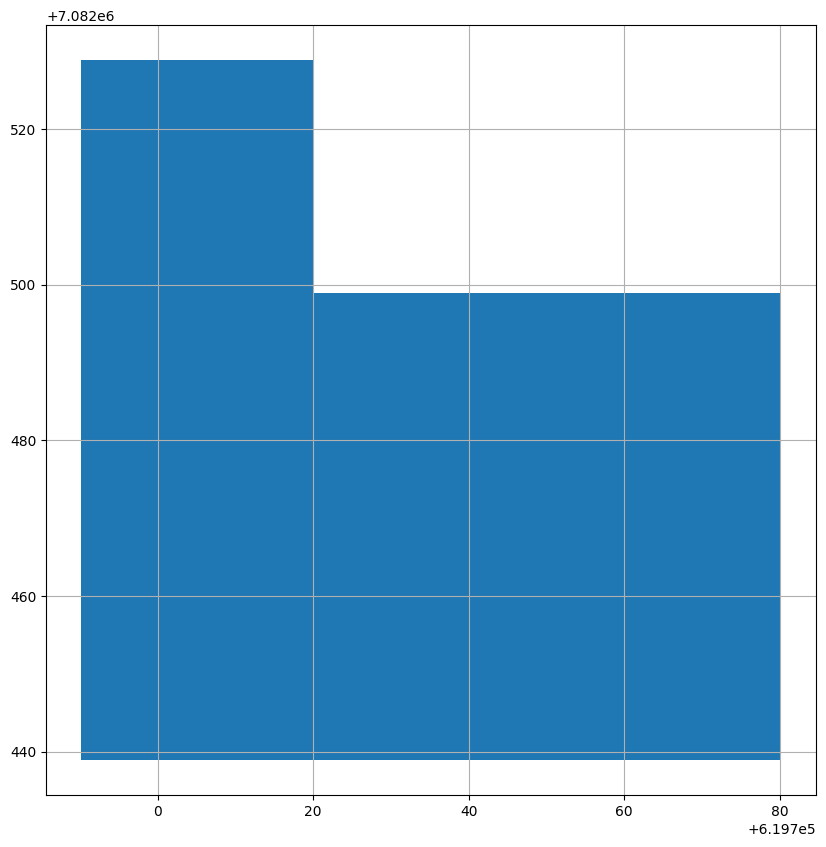

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
index = 7
gdf1.iloc[index:index+1].plot(ax=ax)
ax.grid()